# [1] Import Modules

In [1]:
# ! pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

In [2]:
# ! pip3 install torchsummary ipynb timm

In [3]:
# ! pip install ipynb

In [5]:
import os
import pandas as pd
import numpy as np
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchsummary import summary

from sklearn.utils import shuffle
from PIL import Image

from ipynb.fs.defs.transfer_learning import create_data, Food101Dataset, freeze, \
EarlyStoppingValidator, print_stats, get_optim

In [6]:
# Set a global random seed

RANDOM_SEED = 11919925
torch.manual_seed(RANDOM_SEED)

In [7]:
# Preset batch size, number of epochs, learning rate, loss function, device

batch_size = 128
epochs = 300
lr = 1e-4
loss_fn = nn.CrossEntropyLoss()
device = 'mps' if torch.backends.mps.is_available() else 'cpu'  # MPS for accelerated GPU training on Mac

print(f"Device used: {device}")

Device used: mps


In [8]:
class ModelSaver(object):
    """
    Saves model weights every epoch as long as the validation loss decreases.
    
    As a new version is saved, all old versions are deleted, thus saves storage.
    
    """
    def __init__(self, model, path):
        self.model = model
        self.min_val_loss = np.inf
        self.epochs = []
        self.path = path

    def save(self, epoch_num, val_loss):
        if val_loss < self.min_val_loss:  # Keeps track of the minimum validation loss
            self.min_val_loss = val_loss
            self.epochs.append(epoch_num)
            torch.save(self.model.state_dict(), f'{self.path}/{self.model.__class__.__name__}_Epoch{epoch_num}.pt')
            if len(self.epochs) >= 2:
                os.remove(f'{self.path}/{self.model.__class__.__name__}_Epoch{self.epochs[-2]}.pt')


In [9]:
def train_model(model: nn.Module, loss_fn, optimizer, scheduler, device: str,
                dataloader_train: DataLoader, dataloader_val: DataLoader, 
                epochs:int, path: str, early_stop_delta: float=1e-4) -> list:
    """
    Trains and validates a model.
    
    """
    # Initialise the early stopper and model saver
    earlystop = EarlyStoppingValidator(patience=10, delta=early_stop_delta)
    modelsaver = ModelSaver(model, path)
    
    train_loss_list, val_loss_list = [], []
    training_start_time = time.time()
    
    for epoch in range(epochs):
        # Initialise the running totals for loss
        epoch_train_loss, epoch_val_loss = 0.0, 0.0
        
        # Set the model to training mode
        model.train()
        for train_x, train_y in dataloader_train:
            # Move data and target to the same device as the model
            train_x = train_x.to(device)
            train_y = train_y.to(device)
            
            # Set zero gradients
            optimizer.zero_grad()

            # Forward Propagation to get predicted outcome
            train_pred_y = model(train_x)

            # Compute the training loss
            train_loss = loss_fn(train_pred_y, train_y)

            # Back propagation
            train_loss.backward()

            # Update the weights
            optimizer.step()
            
            # Add the batch loss to the running epoch loss total
            epoch_train_loss += train_loss.item()
        
        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for val_x, val_y in dataloader_val:    
                # Move data and target to the same device as the model
                val_x = val_x.to(device)
                val_y = val_y.to(device)
                
                # Propagate forward to get validation predictions
                val_pred_y = model(val_x)
                
                # Compute the validation loss
                val_loss = loss_fn(val_pred_y, val_y)
                
                # Add the batch loss to the running epoch loss total
                epoch_val_loss += val_loss.item()

        # Normalise the epoch loss running total by the number of batches in each set
        epoch_train_loss /= len(dataloader_train)
        epoch_val_loss /= len(dataloader_val)
        
        # Let the scheduler evaluate epoch validation loss
        scheduler.step(epoch_val_loss)
        
        # Add epoch results to lists for storing
        train_loss_list.append(epoch_train_loss)
        val_loss_list.append(epoch_val_loss)
        
        # Print results
        if (epoch+1 == 1) or ((epoch+1) % 10 == 0):
            epoch_end_time = time.time()
            epoch_elapsed = epoch_end_time - training_start_time
            print(f"EPOCH \t[{epoch+1}/{epochs}] \tTrain Loss {epoch_train_loss:.4f} \tVal Loss {epoch_val_loss:.4f} \t Elapsed time {epoch_elapsed//60:.0f}m {epoch_elapsed%60:.0f}s")
            
        # Save model if validation loss decreases
        modelsaver.save(epoch, epoch_val_loss)
        
        # Evaluate early stopping conditions
        if earlystop.early_stop(epoch_val_loss):
            break
    
    training_end_time = time.time()
    time_elapsed = training_end_time - training_start_time
    
    print(f'==============================================\nTraining completed in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s.')
        
    return train_loss_list, val_loss_list


# [2] Data Preparation

All of the data preparation steps are the same as those in Part A.

In [10]:
# Presets for image transformation: image resolution and mean/std for normalising

img_height, img_width = 224, 224  # Min resolution for all models

mean_imgnet = [0.485, 0.456, 0.406]  # Value taken from ImageNet
std_imgnet = [0.229, 0.224, 0.225]  # Value taken from ImageNet

In [11]:
# Open the meta file that contains all classes

with open("./food-101/meta/classes.txt", "r") as file:
    labels = file.read().splitlines()

In [12]:
# Enumerate the labels to assign a numeric label to each class

labels = {value: key for key, value in enumerate(labels)}

In [13]:
# Define transforms

transform = transforms.Compose(
    [
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_imgnet, std=std_imgnet)
    ]
)

In [14]:
# Create the meta dataframes containing the train and test sets

data_path = "./food-101"

train_imgs = create_data('./food-101/meta/train.txt', data_path=data_path)
test_imgs = create_data('./food-101/meta/test.txt', data_path=data_path)

In [15]:
# Create the dataset class that will hold the actual images

data_train = Food101Dataset(train_imgs, transform=transform, labels=labels)
data_test = Food101Dataset(test_imgs, transform=transform, labels=labels)

In [16]:
# Split the training set into train and validation subsets

train_size = int(0.7 * len(data_train))
val_size = len(data_train) - train_size

data_train, data_val = random_split(data_train, [train_size, val_size])

In [17]:
# Load the datasets into DataLoaders

loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

# [3] Fine-tuning: MobileNetV3

For this section, the following unfreezing strategy will be utilised, each will be trained and validated on the whole dataset:

- **Benchmark model 1**: unfreeze only the classifier 
- **Model 2**: unfreeze all layers from model 1, plus layer 16 (Conv2dNormActivation)
- **Model 3**: unfreeze all layers from model 2, plus layer 15.3 (Conv2dNormActivation)
- **Model 4**: unfreeze all layers from model 3, plus layers 15.2 (SqueezeExcitation)
- **Model 5**: unfreeze all layers from model 4, plus block 15.1 (Conv2dNormActivation)
- **Model 6**: unfreeze all layers from model 5, plus block 15.0 (Conv2dNormActivation)

In [18]:
# MobileNetV3 - original model

mobilenetv3 = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2)

mobilenetv3.classifier = nn.Sequential(
    nn.Linear(in_features=960, out_features=1280, bias=True),  # Same as the first linear layer in the original model
    nn.Hardswish(),  # Same activation
    nn.Dropout(p=0.2, inplace=True),  # Same dropout with rate
    nn.Linear(in_features=1280, out_features=640, bias=True),  # Half the neurons
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=640, out_features=len(labels), bias=True)
)

In [17]:
# For the current random seed, the best performing model is in Epoch 37
mobilenetv3.load_state_dict(torch.load(f'./checkpoints/{mobilenetv3.__class__.__name__}_Epoch{37}.pt'))

<All keys matched successfully>

## [3.1] Benchmark model: MobileNetV3_1

In [19]:
# Deep copy the model and send to device

mobilenetv3_1 = copy.deepcopy(mobilenetv3)
mobilenetv3_1.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [20]:
# Freeze only the classifier

for name, param in mobilenetv3_1.named_parameters():
    if not name.startswith("classifier"):
        param.requires_grad = False

In [21]:
# Create a checkpoints folder
checkpoints_finetune_path1 = './checkpoints_finetune1'
if not os.path.exists(checkpoints_finetune_path1):
    os.makedirs(checkpoints_finetune_path1)

# Create the optimiser and learning rate scheduler
optim_mobilenetv3_1 = get_optim(mobilenetv3_1, lr)
lr_scheduler_mobilenetv3_1 = ReduceLROnPlateau(optim_mobilenetv3_1, mode='min', factor=0.1, patience=3, min_lr=1e-6)

# Train and validate
train_loss_mobilenetv3_1, val_loss_mobilenetv3_1 = train_model(model=mobilenetv3_1, 
                                                               loss_fn=loss_fn, 
                                                               optimizer=optim_mobilenetv3_1, 
                                                               scheduler=lr_scheduler_mobilenetv3_1,
                                                               device=device, 
                                                               dataloader_train=loader_train, 
                                                               dataloader_val=loader_val, 
                                                               epochs=epochs,
                                                               path=checkpoints_finetune_path1)

EPOCH 	[1/300] 	Train Loss 2.2995 	Val Loss 2.1009 	 Elapsed time 5m 16s
EPOCH 	[10/300] 	Train Loss 1.6340 	Val Loss 1.7789 	 Elapsed time 236m 44s
EPOCH 	[20/300] 	Train Loss 1.3515 	Val Loss 1.7191 	 Elapsed time 524m 53s
EPOCH 	[30/300] 	Train Loss 1.1166 	Val Loss 1.7101 	 Elapsed time 816m 57s
Training completed in 875m 5s.


Training this model was slower than expected because GPU acceleration was accidentally turned off for a couple of hours when the screen turned off. The next instances will utilise full GPU training, so the expected training time per epoch will be around 5-6 minutes.

## [3.2] Model: MobileNetV3_2

In [22]:
mobilenetv3_2 = copy.deepcopy(mobilenetv3)
mobilenetv3_2.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [23]:
# Freeze the classifier and block 16

for name, param in mobilenetv3_2.named_parameters():
    if not ((name.startswith("classifier")) or (name.startswith("features.16"))):
        param.requires_grad = False

In [24]:
checkpoints_finetune_path2 = './checkpoints_finetune2'
if not os.path.exists(checkpoints_finetune_path2):
    os.makedirs(checkpoints_finetune_path2)
    
optim_mobilenetv3_2 = get_optim(mobilenetv3_2, lr)
lr_scheduler_mobilenetv3_2 = ReduceLROnPlateau(optim_mobilenetv3_2, mode='min', factor=0.1, patience=3, min_lr=1e-6)

train_loss_mobilenetv3_2, val_loss_mobilenetv3_2 = train_model(model=mobilenetv3_2, 
                                                               loss_fn=loss_fn, 
                                                               optimizer=optim_mobilenetv3_2, 
                                                               scheduler=lr_scheduler_mobilenetv3_2,
                                                               device=device, 
                                                               dataloader_train=loader_train, 
                                                               dataloader_val=loader_val, 
                                                               epochs=epochs,
                                                               path=checkpoints_finetune_path2)

EPOCH 	[1/300] 	Train Loss 2.2514 	Val Loss 2.0284 	 Elapsed time 5m 23s
EPOCH 	[10/300] 	Train Loss 1.3084 	Val Loss 1.5713 	 Elapsed time 53m 47s
EPOCH 	[20/300] 	Train Loss 0.8777 	Val Loss 1.5380 	 Elapsed time 107m 27s
Training completed in 144m 60s.


## [3.3] Model: MobileNetV3_3

In [37]:
mobilenetv3_3 = copy.deepcopy(mobilenetv3)
mobilenetv3_3.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [39]:
# Freeze the classifier, block 16, and block 15.3
for name, param in mobilenetv3_3.named_parameters():
    if not ((name.startswith("classifier")) or (name.startswith("features.16")) or 
            (name.startswith("features.15.block.3"))):
        param.requires_grad = False

In [40]:
checkpoints_finetune_path3 = './checkpoints_finetune3'
if not os.path.exists(checkpoints_finetune_path3):
    os.makedirs(checkpoints_finetune_path3)

optim_mobilenetv3_3 = get_optim(mobilenetv3_3, lr)
lr_scheduler_mobilenetv3_3 = ReduceLROnPlateau(optim_mobilenetv3_3, mode='min', factor=0.1, patience=3, min_lr=1e-6)

train_loss_mobilenetv3_3, val_loss_mobilenetv3_3 = train_model(model=mobilenetv3_3, 
                                                               loss_fn=loss_fn, 
                                                               optimizer=optim_mobilenetv3_3, 
                                                               scheduler=lr_scheduler_mobilenetv3_3,
                                                               device=device, 
                                                               dataloader_train=loader_train, 
                                                               dataloader_val=loader_val, 
                                                               epochs=epochs,
                                                               path=checkpoints_finetune_path3)

EPOCH 	[1/300] 	Train Loss 2.1627 	Val Loss 1.9149 	 Elapsed time 5m 25s
EPOCH 	[10/300] 	Train Loss 1.1144 	Val Loss 1.4746 	 Elapsed time 53m 45s
EPOCH 	[20/300] 	Train Loss 0.7316 	Val Loss 1.4809 	 Elapsed time 107m 30s
Training completed in 134m 21s.


## [3.4] Model: MobileNetV3_4

In [41]:
mobilenetv3_4 = copy.deepcopy(mobilenetv3)
mobilenetv3_4.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [42]:
# Freeze the classifier, block 16, block 15.3, and block 15.2

for name, param in mobilenetv3_4.named_parameters():
    if not ((name.startswith("classifier")) or (name.startswith("features.16")) or \
            (name.startswith("features.15.block.3")) or (name.startswith("features.15.block.2"))):
        param.requires_grad = False

In [43]:
checkpoints_finetune_path4 = './checkpoints_finetune4'
if not os.path.exists(checkpoints_finetune_path4):
    os.makedirs(checkpoints_finetune_path4)

optim_mobilenetv3_4 = get_optim(mobilenetv3_4, lr)
lr_scheduler_mobilenetv3_4 = ReduceLROnPlateau(optim_mobilenetv3_4, mode='min', factor=0.1, patience=3, min_lr=1e-6)

train_loss_mobilenetv3_4, val_loss_mobilenetv3_4 = train_model(model=mobilenetv3_4, 
                                                               loss_fn=loss_fn, 
                                                               optimizer=optim_mobilenetv3_4, 
                                                               scheduler=lr_scheduler_mobilenetv3_4,
                                                               device=device, 
                                                               dataloader_train=loader_train, 
                                                               dataloader_val=loader_val, 
                                                               epochs=epochs,
                                                               path=checkpoints_finetune_path4)

EPOCH 	[1/300] 	Train Loss 2.1189 	Val Loss 1.8583 	 Elapsed time 5m 23s
EPOCH 	[10/300] 	Train Loss 0.9349 	Val Loss 1.5364 	 Elapsed time 53m 54s
Training completed in 102m 22s.


## [3.5] Model: MobileNetV3_5

In [44]:
mobilenetv3_5 = copy.deepcopy(mobilenetv3)
mobilenetv3_5.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [45]:
# Freeze the classifier, block 16, block 15.3, block 15.2, and block 15.1
for name, param in mobilenetv3_5.named_parameters():
    if not ((name.startswith("classifier")) or (name.startswith("features.16")) or \
            (name.startswith("features.15.block.3")) or (name.startswith("features.15.block.2")) or \
            (name.startswith("features.15.block.1"))):
        param.requires_grad = False

In [46]:
checkpoints_finetune_path5 = './checkpoints_finetune5'
if not os.path.exists(checkpoints_finetune_path5):
    os.makedirs(checkpoints_finetune_path5)

optim_mobilenetv3_5 = get_optim(mobilenetv3_5, lr)
lr_scheduler_mobilenetv3_5 = ReduceLROnPlateau(optim_mobilenetv3_5, mode='min', factor=0.1, patience=3, min_lr=1e-6)

train_loss_mobilenetv3_5, val_loss_mobilenetv3_5 = train_model(model=mobilenetv3_5, 
                                                               loss_fn=loss_fn, 
                                                               optimizer=optim_mobilenetv3_5, 
                                                               scheduler=lr_scheduler_mobilenetv3_5,
                                                               device=device, 
                                                               dataloader_train=loader_train, 
                                                               dataloader_val=loader_val, 
                                                               epochs=epochs,
                                                               path=checkpoints_finetune_path5)

EPOCH 	[1/300] 	Train Loss 2.1118 	Val Loss 1.8597 	 Elapsed time 5m 26s
EPOCH 	[10/300] 	Train Loss 0.8996 	Val Loss 1.5522 	 Elapsed time 54m 22s
Training completed in 97m 49s.


## [3.6] Model: MobileNetV3_6

In [47]:
mobilenetv3_6 = copy.deepcopy(mobilenetv3)
mobilenetv3_6.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [48]:
# Freeze the classifier, block 16, block 15.3, block 15.2, block 15.1, and block 15.0
for name, param in mobilenetv3_6.named_parameters():
    if not ((name.startswith("classifier")) or (name.startswith("features.16")) or \
            (name.startswith("features.15.block.3")) or (name.startswith("features.15.block.2")) or \
            (name.startswith("features.15.block.1")) or (name.startswith("features.15.block.0"))):
        param.requires_grad = False

In [49]:
checkpoints_finetune_path6 = './checkpoints_finetune6'
if not os.path.exists(checkpoints_finetune_path6):
    os.makedirs(checkpoints_finetune_path6)

optim_mobilenetv3_6 = get_optim(mobilenetv3_6, lr)
lr_scheduler_mobilenetv3_6 = ReduceLROnPlateau(optim_mobilenetv3_6, mode='min', factor=0.1, patience=3, min_lr=1e-6)

train_loss_mobilenetv3_6, val_loss_mobilenetv3_6 = train_model(model=mobilenetv3_6, 
                                                               loss_fn=loss_fn, 
                                                               optimizer=optim_mobilenetv3_6, 
                                                               scheduler=lr_scheduler_mobilenetv3_6,
                                                               device=device, 
                                                               dataloader_train=loader_train, 
                                                               dataloader_val=loader_val, 
                                                               epochs=epochs,
                                                               path=checkpoints_finetune_path6)

EPOCH 	[1/300] 	Train Loss 2.0771 	Val Loss 1.8118 	 Elapsed time 5m 33s
EPOCH 	[10/300] 	Train Loss 0.6922 	Val Loss 1.6187 	 Elapsed time 55m 10s
Training completed in 99m 18s.


# [4] Analysis of results

In [50]:
# MobileNetV3_1
print_stats(mobilenetv3_1, val_loss_mobilenetv3_1)

MobileNetV3: Total epochs trained: 39, Best epoch: 28, Validation Loss: 1.708553507086936


In [51]:
# MobileNetV3_2
print_stats(mobilenetv3_2, val_loss_mobilenetv3_2)

MobileNetV3: Total epochs trained: 27, Best epoch: 16, Validation Loss: 1.5266494114747209


In [52]:
# MobileNetV3_3 - Winner
print_stats(mobilenetv3_3, val_loss_mobilenetv3_3)

MobileNetV3: Total epochs trained: 25, Best epoch: 14, Validation Loss: 1.467375089278382


In [53]:
# MobileNetV3_4
print_stats(mobilenetv3_4, val_loss_mobilenetv3_4)

MobileNetV3: Total epochs trained: 19, Best epoch: 8, Validation Loss: 1.5143105173378848


In [54]:
# MobileNetV3_5
print_stats(mobilenetv3_5, val_loss_mobilenetv3_5)

MobileNetV3: Total epochs trained: 18, Best epoch: 7, Validation Loss: 1.5016576239232267


In [55]:
# MobileNetV3_6
print_stats(mobilenetv3_6, val_loss_mobilenetv3_6)

MobileNetV3: Total epochs trained: 18, Best epoch: 7, Validation Loss: 1.4764046334148793


In [66]:
import matplotlib.pyplot as plt


def plot_learning_curves(model: nn.Module, train_loss: list, val_loss: list, epochs: int, model_num: int) -> None:
    """
    Plots the learning curve of the model
    """
    plt.plot(range(epochs), train_loss, label='Training Loss')
    plt.plot(range(epochs), val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model.__class__.__name__}_{model_num} learning curve', weight='bold')
    plt.legend()

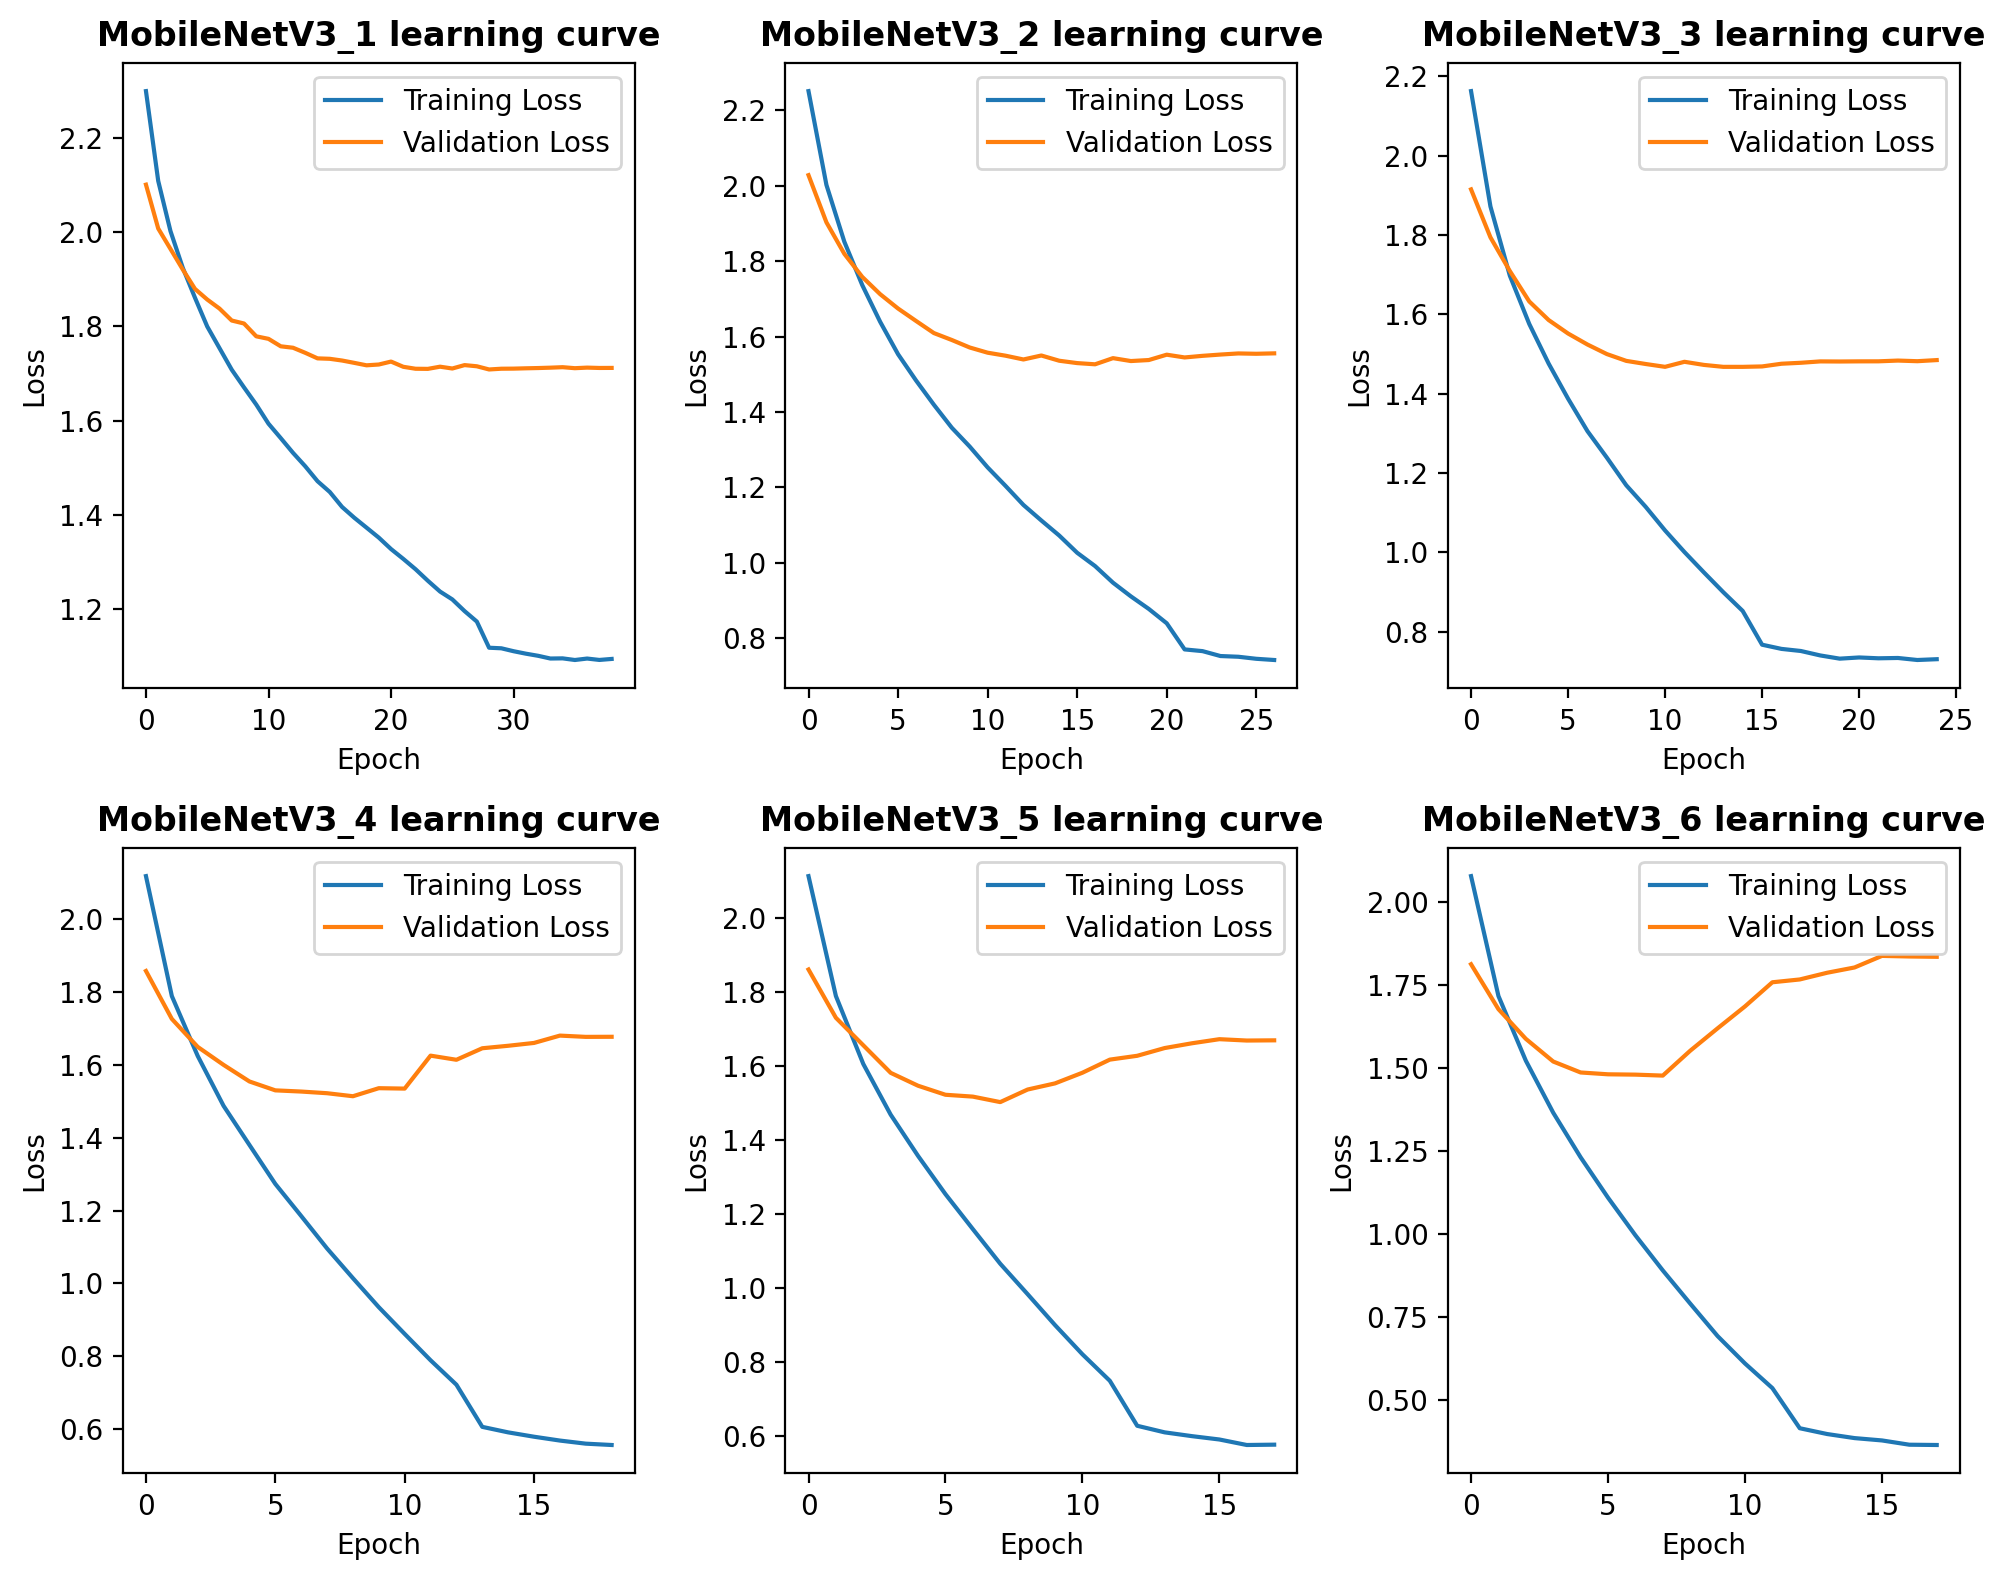

In [69]:
# Put all results and models to lists for iterating plots
all_models = [mobilenetv3_1, mobilenetv3_2, mobilenetv3_3, mobilenetv3_4, mobilenetv3_5, mobilenetv3_6]
all_train_losses = [train_loss_mobilenetv3_1, train_loss_mobilenetv3_2, train_loss_mobilenetv3_3,
                    train_loss_mobilenetv3_4, train_loss_mobilenetv3_5, train_loss_mobilenetv3_6]
all_val_losses = [val_loss_mobilenetv3_1, val_loss_mobilenetv3_2, val_loss_mobilenetv3_3, 
                  val_loss_mobilenetv3_4, val_loss_mobilenetv3_5, val_loss_mobilenetv3_6]


rows, cols = 2, 3
fig = plt.figure(figsize=(10, 8), dpi=200)

for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    plot_learning_curves(all_models[i], all_train_losses[i], all_val_losses[i], len(all_val_losses[i]), i+1)
    
fig.tight_layout()

From the validation losses and the plots, it is now clear that version 3 is the winner. Versions 4 to 6 unlocked more layers for tuning, but led to overfitting, as seen in the validation loss shoot-up towards the later half of training. This may be due to insufficiently small learning rates, which may be helped by decaying the rate to a greater extent, at the expense of slower training.

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score


def eval_model(model: nn.Module, device: str, dataloader: DataLoader, return_conf_matx=False):
    """
    Evaluates the best model on a given dataset.
    
    """
    model.to(device)
    model.eval()
    y_true_concat, y_pred_concat = torch.LongTensor(), torch.LongTensor()
    with torch.no_grad():
        for X, y in dataloader:
            # Only send X to the GPU accelerator
            X = X.to(device)
            
            y_pred = model(X)
            y_pred = torch.argmax(y_pred, dim=1).cpu()
            y_true_concat = torch.cat((y_true_concat, y))
            y_pred_concat = torch.cat((y_pred_concat, y_pred))
    
    acc_score = accuracy_score(y_true_concat, y_pred_concat)
    
    if return_conf_matx:
        conf_matx = confusion_matrix(y_true_concat, y_pred_concat)
        return acc_score, conf_matx
    return acc_score

In [22]:
# For the current random seed, the best performing model is in Epoch 37
mobilenetv3.load_state_dict(torch.load(f'./checkpoints_finetune3/{mobilenetv3.__class__.__name__}_Epoch{14}.pt'))

<All keys matched successfully>

In [25]:
mobilenetv3_3_acc, mobilenetv3_3_conf_matx = eval_model(model=mobilenetv3, device=device, 
                                                        dataloader=loader_test, 
                                                        return_conf_matx=True)

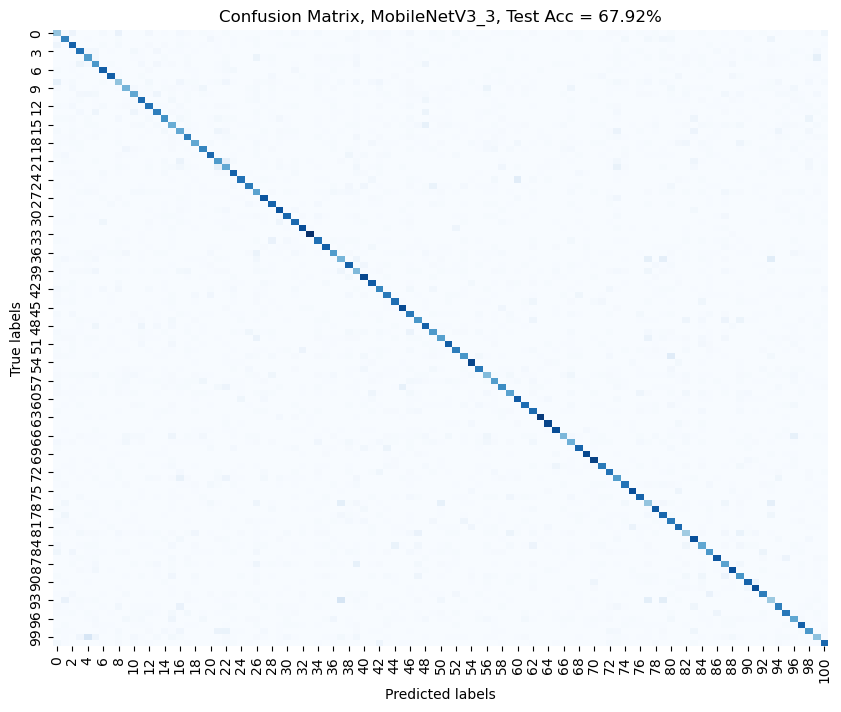

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(mobilenetv3_3_conf_matx, annot=False, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix, {mobilenetv3.__class__.__name__}_3, Test Acc = {mobilenetv3_3_acc*100:.2f}%')
plt.show()

Test accuracy dramatically improved, now standing at 68.32% compared to 46.69% in part A. This is thanks to a larger training dataset, allowing the model to learn more features.

This result is still shy comparing to the state-of-the-art top-1 accuracy of 75.2% of MobileNetV3-Large on the ImageNet dataset, suggesting that there is still work to be done in terms of training design.